In [2]:
import os
import re
import numpy as np
import librosa
import scipy.signal
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from collections import OrderedDict
import pandas as pd

# Testing Manual Particle Movement Experiment Calibration


## MRM 1 - Impact Pipe

C:\Users\nicol\AppData\Local\Temp\ipykernel_4080\56214427.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\nicol\anaconda3\envs\hydrophones\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


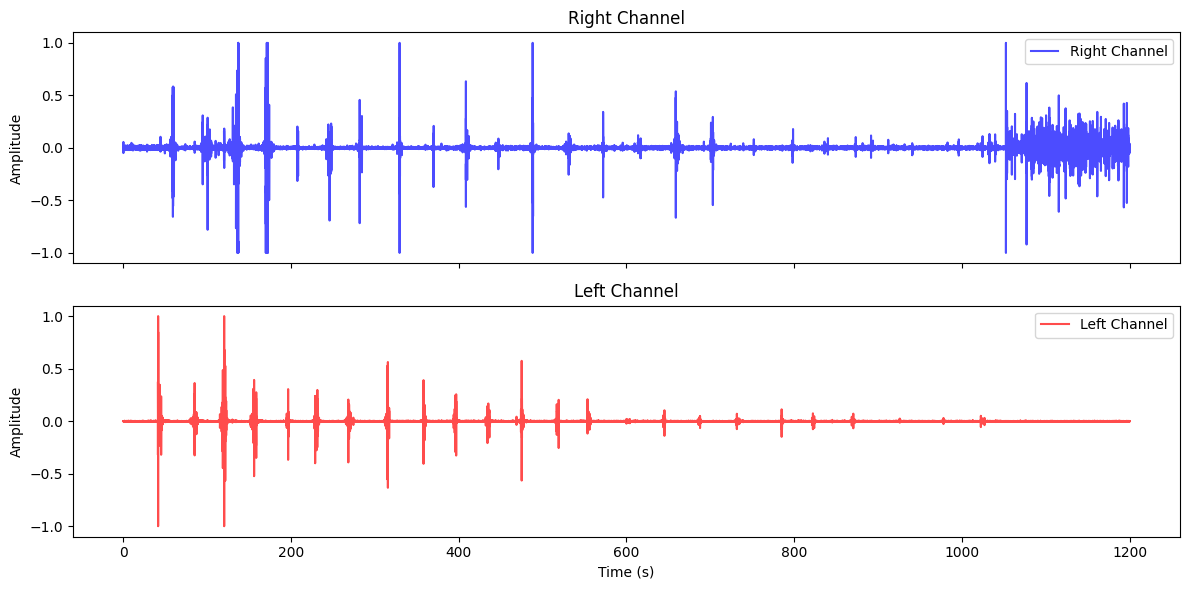

In [3]:
filepath = 'ManualRockMovements-1/audio/Nicole_091823-000100.flac'

# load stereo signal
signal, sr = librosa.load(filepath, sr=None, mono=False)
left_channel = signal[0]
right_channel = signal[1]

#create the time axis
duration = signal.shape[-1] / sr
time = np.linspace(0, duration, signal.shape[-1])

# plot the signals
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# plot the right channel (top)
axes[0].plot(time, signal[1], label='Right Channel', color='b', alpha=0.7)
axes[0].set_title("Right Channel")
axes[0].set_ylabel("Amplitude")
axes[0].legend()

# plot the left channel (bottom)
axes[1].plot(time, signal[0], label='Left Channel', color='r', alpha=0.7)
axes[1].set_title("Left Channel")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].legend()

# adjust layout to prevent overlap
plt.tight_layout()
plt.show()


The left channel is the impact pipe. This is true for all calibration recordings for H1 in 2023

#### Compute and plotting envelope

In [4]:
# === USER INPUT ===
left_gain_db = 23   # left channel gain (dB)
right_gain_db = 4 # right channel gain (dB)
use_channel = "left"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

Plotting envelope and packets

C:\Users\nicol\AppData\Local\Temp\ipykernel_4080\3310124320.py:23: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


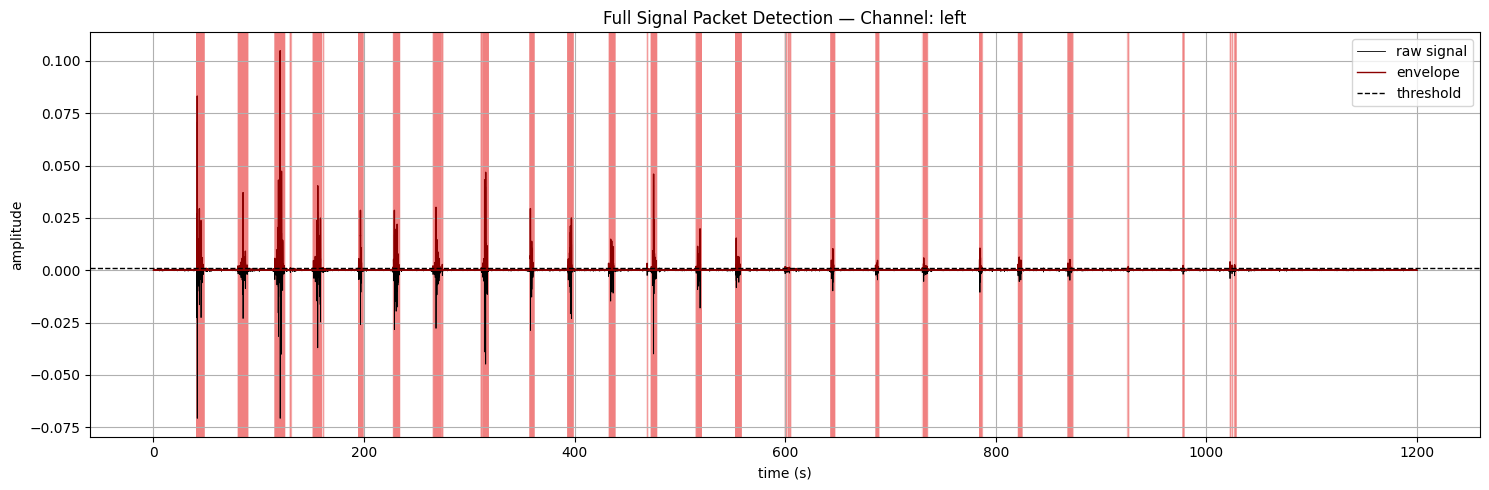

In [5]:
time = np.arange(len(y)) / sr

# plot
plt.figure(figsize=(15, 5))
plt.plot(time, y, color='black', linewidth=0.6, label="raw signal")
plt.plot(time, envelope, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# shade packet zones
for s, e in zip(packet_starts, packet_ends):
    plt.axvspan(time[s], time[e], color='lightcoral', alpha=0.4)

# De-duplicate Δtₚ label in legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]  # safety check
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Full Signal Packet Detection — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\nicol\AppData\Local\Temp\ipykernel_4080\3768854100.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


Max amplitude in the zoomed-in window: 0.10


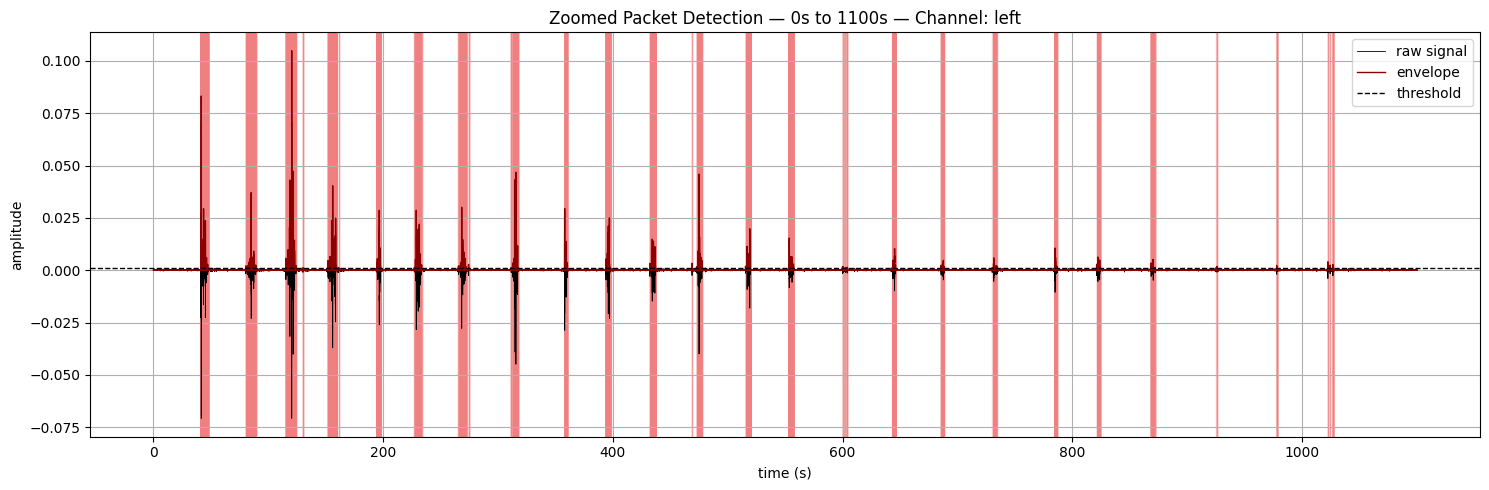

In [6]:
start_time = 0  # in seconds
end_time = 1100  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Zoomed Packet Detection — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_amplitude_zoom = np.max(np.abs(envelope_zoom))
print(f"Max amplitude in the zoomed-in window: {max_amplitude_zoom:.2f}")

plt.show()


In [7]:
# how many packets were detected?
print(f"Detected {len(packet_starts)} packets in {len(y)/sr:.2f} seconds of audio.")

Detected 5354 packets in 1200.00 seconds of audio.


Plotting and Saving Rock Movement Calibrations

In [8]:
# import csv
csv_path = 'ManualRockMovements-1/mov1_particles.csv'
times_df = pd.read_csv(csv_path)

# Make sure "plots" folder exists
os.makedirs('ManualRockMovements-1/plots', exist_ok=True)

# Iterate through each row of the dataframe
for idx, row in times_df.iterrows():
    id_num = row['id']
    start_time = row['start_time']
    end_time = row['end_time']
    
    # Convert times to sample indices
    start_idx = int(start_time * sr)
    end_idx = int(end_time * sr)

    # Slice the arrays
    y_zoom = y[start_idx:end_idx]
    envelope_zoom = envelope[start_idx:end_idx]
    time_zoom = np.arange(start_idx, end_idx) / sr

    # Create the plot
    plt.figure(figsize=(15, 5))
    plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
    plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
    plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

    # Shade packets only if within the zoomed window
    for start, end in zip(packet_starts, packet_ends):
        if start >= start_idx and end <= end_idx:
            plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

    # Clean up legend
    handles, labels = plt.gca().get_legend_handles_labels()
    labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.xlabel("time (s)")
    plt.ylabel("amplitude")
    plt.title(f"Zoomed Packet Detection — Particle ID: {id_num} — {start_time}s to {end_time}s — Channel: {use_channel}")
    plt.grid(True)
    plt.tight_layout()

    # Save the figure
    plot_filename = f"ManualRockMovements-1/plots/pipe_signal_{id_num}.png"
    plt.savefig(plot_filename, dpi=300)
    plt.close()

    print(f"Saved plot for group {id_num} to {plot_filename}")

Saved plot for group 167 to ManualRockMovements-1/plots/pipe_signal_167.png
Saved plot for group 6 to ManualRockMovements-1/plots/pipe_signal_6.png
Saved plot for group 8 to ManualRockMovements-1/plots/pipe_signal_8.png
Saved plot for group 168 to ManualRockMovements-1/plots/pipe_signal_168.png
Saved plot for group 150 to ManualRockMovements-1/plots/pipe_signal_150.png
Saved plot for group 11 to ManualRockMovements-1/plots/pipe_signal_11.png
Saved plot for group 22 to ManualRockMovements-1/plots/pipe_signal_22.png
Saved plot for group 152 to ManualRockMovements-1/plots/pipe_signal_152.png
Saved plot for group 12 to ManualRockMovements-1/plots/pipe_signal_12.png
Saved plot for group 96 to ManualRockMovements-1/plots/pipe_signal_96.png
Saved plot for group 101 to ManualRockMovements-1/plots/pipe_signal_101.png
Saved plot for group 24 to ManualRockMovements-1/plots/pipe_signal_24.png
Saved plot for group 107 to ManualRockMovements-1/plots/pipe_signal_107.png
Saved plot for group 162 to Ma

Displaying the max amplitude for each particle ID

In [9]:
# loop through each row of the DataFrame
for idx, row in times_df.iterrows():
    id_num = row['id']
    start_time = row['start_time']
    end_time = row['end_time']

    # convert to sample indices
    start_idx = int(start_time * sr)
    end_idx = int(end_time * sr)

    # slice the raw signal
    y_zoom = y[start_idx:end_idx]

    # get max amplitude
    max_amp = np.max(np.abs(y_zoom))

    print(f"Particle ID {id_num}: Max amplitude = {max_amp:.4f}")


Particle ID 167: Max amplitude = 0.0708
Particle ID 6: Max amplitude = 0.0257
Particle ID 8: Max amplitude = 0.0708
Particle ID 168: Max amplitude = 0.0371
Particle ID 150: Max amplitude = 0.0261
Particle ID 11: Max amplitude = 0.0284
Particle ID 22: Max amplitude = 0.0278
Particle ID 152: Max amplitude = 0.0449
Particle ID 12: Max amplitude = 0.0288
Particle ID 96: Max amplitude = 0.0232
Particle ID 101: Max amplitude = 0.0148
Particle ID 24: Max amplitude = 0.0407
Particle ID 107: Max amplitude = 0.0181
Particle ID 162: Max amplitude = 0.0148
Particle ID 159: Max amplitude = 0.0017
Particle ID 35: Max amplitude = 0.0099
Particle ID 69: Max amplitude = 0.0046
Particle ID 85: Max amplitude = 0.0054
Particle ID 61: Max amplitude = 0.0106
Particle ID 52: Max amplitude = 0.0054
Particle ID 165: Max amplitude = 0.0051
Particle ID 166: Max amplitude = 0.0018
Particle ID 53: Max amplitude = 0.0022
Particle ID 45: Max amplitude = 0.0040


## MRM 1 - Hydrophone

In [10]:
# === USER INPUT ===
left_gain_db = 23   # left channel gain (dB)
right_gain_db = 4 # right channel gain (dB)
use_channel = "right"  # which one was the hydrophone

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

Plotting envelope and packets

C:\Users\nicol\AppData\Local\Temp\ipykernel_4080\3310124320.py:23: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\nicol\anaconda3\envs\hydrophones\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


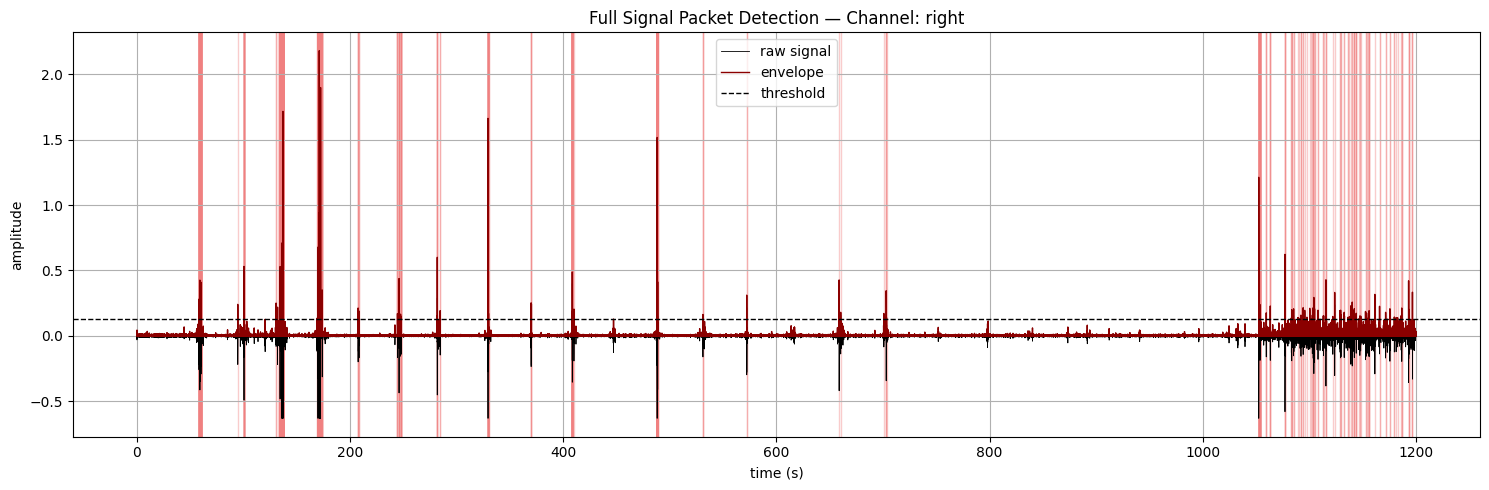

In [11]:
time = np.arange(len(y)) / sr

# plot
plt.figure(figsize=(15, 5))
plt.plot(time, y, color='black', linewidth=0.6, label="raw signal")
plt.plot(time, envelope, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# shade packet zones
for s, e in zip(packet_starts, packet_ends):
    plt.axvspan(time[s], time[e], color='lightcoral', alpha=0.4)

# De-duplicate Δtₚ label in legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]  # safety check
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Full Signal Packet Detection — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
# how many packets were detected?
print(f"Detected {len(packet_starts)} packets in {len(y)/sr:.2f} seconds of audio.")

Detected 550 packets in 1200.00 seconds of audio.


Plotting and Saving Rock Movement Calibrations

In [13]:
# import csv
csv_path = 'ManualRockMovements-1/mov1_particles.csv'
times_df = pd.read_csv(csv_path)

# Make sure "plots" folder exists
os.makedirs('ManualRockMovements-1/plots/hydrophones', exist_ok=True)

# Iterate through each row of the dataframe
for idx, row in times_df.iterrows():
    id_num = row['id']
    start_time = row['start_time']
    end_time = row['end_time']
    
    # Convert times to sample indices
    start_idx = int(start_time * sr)
    end_idx = int(end_time * sr)

    # Slice the arrays
    y_zoom = y[start_idx:end_idx]
    envelope_zoom = envelope[start_idx:end_idx]
    time_zoom = np.arange(start_idx, end_idx) / sr

    # Create the plot
    plt.figure(figsize=(15, 5))
    plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
    plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
    plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

    # Shade packets only if within the zoomed window
    for start, end in zip(packet_starts, packet_ends):
        if start >= start_idx and end <= end_idx:
            plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

    # Clean up legend
    handles, labels = plt.gca().get_legend_handles_labels()
    labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.xlabel("time (s)")
    plt.ylabel("amplitude")
    plt.title(f"Zoomed Packet Detection — Particle ID: {id_num} — {start_time}s to {end_time}s — Channel: {use_channel}")
    plt.grid(True)
    plt.tight_layout()

    # Save the figure
    plot_filename = f"ManualRockMovements-1/plots/hydrophones/mic_signal_{id_num}.png"
    plt.savefig(plot_filename, dpi=300)
    plt.close()

Displaying the max amplitude for each particle ID 

In [14]:
# loop through each row of the DataFrame
for idx, row in times_df.iterrows():
    id_num = row['id']
    start_time = row['start_time']
    end_time = row['end_time']

    # convert to sample indices
    start_idx = int(start_time * sr)
    end_idx = int(end_time * sr)

    # slice the raw signal
    y_zoom = y[start_idx:end_idx]

    # get max amplitude
    max_amp = np.max(np.abs(y_zoom))

    print(f"Particle ID {id_num}: Max amplitude = {max_amp:.4f}")


Particle ID 167: Max amplitude = 0.0667
Particle ID 6: Max amplitude = 0.0379
Particle ID 8: Max amplitude = 0.1208
Particle ID 168: Max amplitude = 0.0203
Particle ID 150: Max amplitude = 0.0122
Particle ID 11: Max amplitude = 0.0199
Particle ID 22: Max amplitude = 0.0147
Particle ID 152: Max amplitude = 0.0080
Particle ID 12: Max amplitude = 0.0075
Particle ID 96: Max amplitude = 0.0127
Particle ID 101: Max amplitude = 0.0103
Particle ID 24: Max amplitude = 0.0149
Particle ID 107: Max amplitude = 0.0109
Particle ID 162: Max amplitude = 0.0168
Particle ID 159: Max amplitude = 0.0313
Particle ID 35: Max amplitude = 0.0123
Particle ID 69: Max amplitude = 0.0096
Particle ID 85: Max amplitude = 0.0124
Particle ID 61: Max amplitude = 0.0173
Particle ID 52: Max amplitude = 0.0186
Particle ID 165: Max amplitude = 0.0650
Particle ID 166: Max amplitude = 0.0154
Particle ID 53: Max amplitude = 0.0323
Particle ID 45: Max amplitude = 0.0703


## MRM 2 - Impact Pipe

# Flood Experiments

### Flood 1

Import file and check left and right gain to see which is the impact pipe

C:\Users\nicol\AppData\Local\Temp\ipykernel_28484\626725145.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\nicol\anaconda3\envs\hydrophones\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


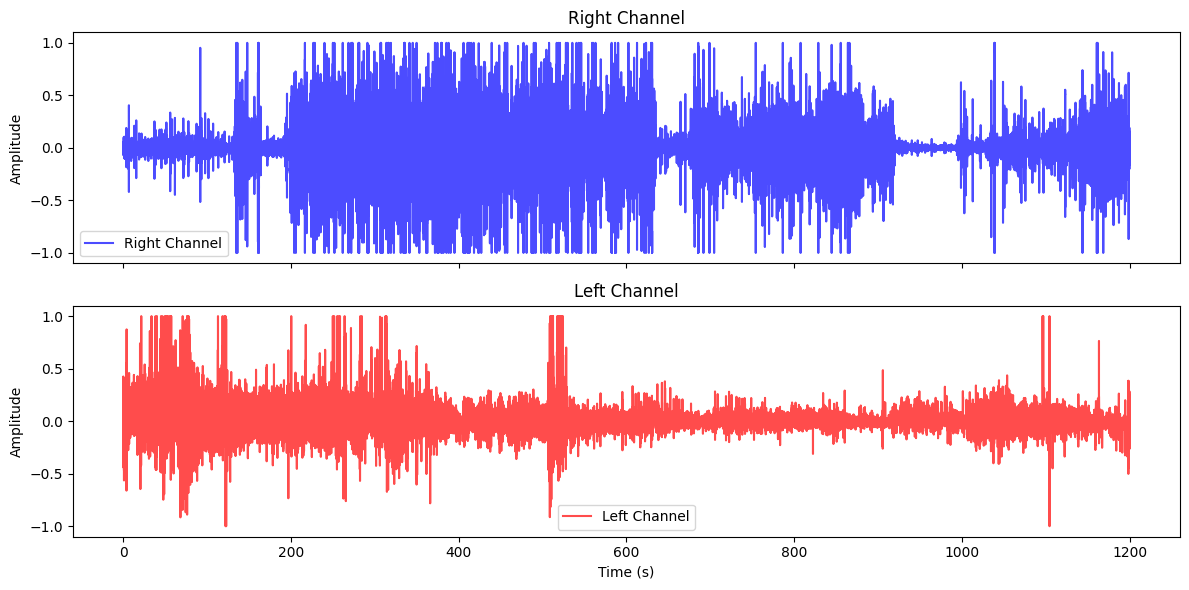

In [2]:
filepath = 'EXP-09-20-23-FLOW1/audio/Nicole_091823-000100.flac'

# load stereo signal
signal, sr = librosa.load(filepath, sr=None, mono=False)
left_channel = signal[0]
right_channel = signal[1]

#create the time axis
duration = signal.shape[-1] / sr
time = np.linspace(0, duration, signal.shape[-1])

# plot the signals
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# plot the right channel (top)
axes[0].plot(time, signal[1], label='Right Channel', color='b', alpha=0.7)
axes[0].set_title("Right Channel")
axes[0].set_ylabel("Amplitude")
axes[0].legend()

# plot the left channel (bottom)
axes[1].plot(time, signal[0], label='Left Channel', color='r', alpha=0.7)
axes[1].set_title("Left Channel")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].legend()

# adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Flood 1 pipe recordings are unusable. For some reason there was a lot of static in the recordings, don't know if it was like a hardware thing? 

### Flood 2

C:\Users\nicol\AppData\Local\Temp\ipykernel_28484\3555298314.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


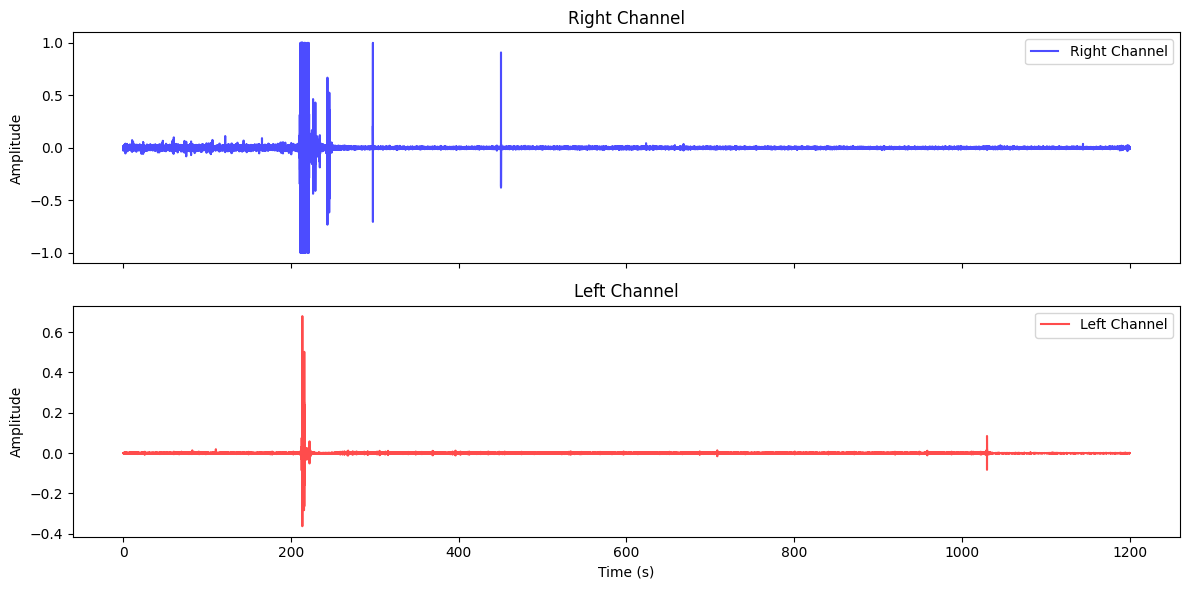

In [3]:
filepath = 'EXP-09-20-23-FLOW2/audio/Nicole_091823-000100.flac'

# load stereo signal
signal, sr = librosa.load(filepath, sr=None, mono=False)
left_channel = signal[0]
right_channel = signal[1]

#create the time axis
duration = signal.shape[-1] / sr
time = np.linspace(0, duration, signal.shape[-1])

# plot the signals
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# plot the right channel (top)
axes[0].plot(time, signal[1], label='Right Channel', color='b', alpha=0.7)
axes[0].set_title("Right Channel")
axes[0].set_ylabel("Amplitude")
axes[0].legend()

# plot the left channel (bottom)
axes[1].plot(time, signal[0], label='Left Channel', color='r', alpha=0.7)
axes[1].set_title("Left Channel")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].legend()

# adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [4]:
# === USER INPUT ===
left_gain_db = 6   # left channel gain (dB)
right_gain_db = 12 # right channel gain (dB)
use_channel = "left"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

Max amplitude in the zoomed-in window: 0.3447


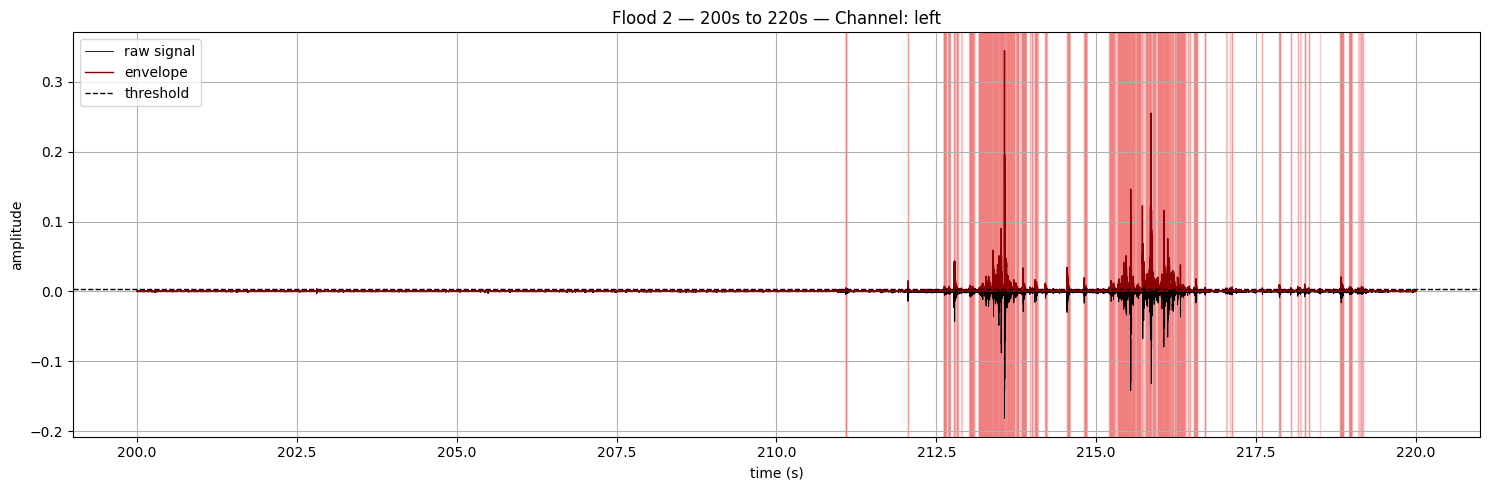

In [5]:
start_time = 200  # in seconds
end_time = 220  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Flood 2 — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_amplitude_zoom = np.max(np.abs(envelope_zoom))
print(f"Max amplitude in the zoomed-in window: {max_amplitude_zoom:.4f}")

plt.show()


### Flood 3

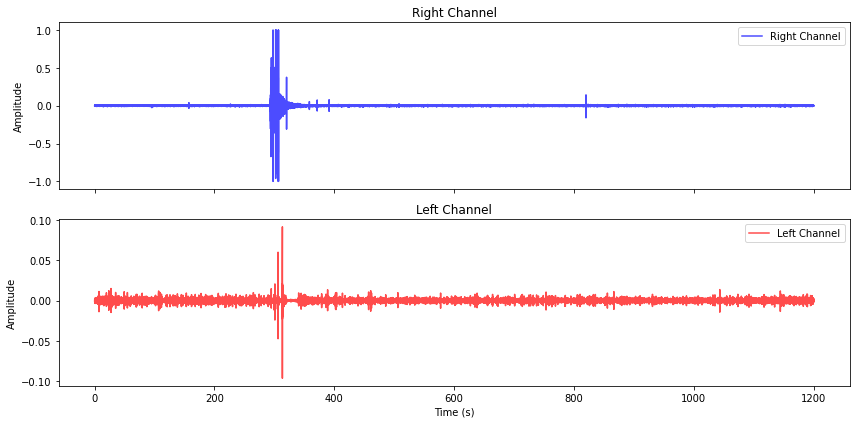

In [20]:
filepath = 'EXP-09-20-23-FLOW3/audio/Nicole_091823-000100.flac'

# load stereo signal
signal, sr = librosa.load(filepath, sr=None, mono=False)
left_channel = signal[0]
right_channel = signal[1]

#create the time axis
duration = signal.shape[-1] / sr
time = np.linspace(0, duration, signal.shape[-1])

# plot the signals
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# plot the right channel (top)
axes[0].plot(time, signal[1], label='Right Channel', color='b', alpha=0.7)
axes[0].set_title("Right Channel")
axes[0].set_ylabel("Amplitude")
axes[0].legend()

# plot the left channel (bottom)
axes[1].plot(time, signal[0], label='Left Channel', color='r', alpha=0.7)
axes[1].set_title("Left Channel")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].legend()

# adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [21]:
# === USER INPUT ===
left_gain_db = 6   # left channel gain (dB)
right_gain_db = 12 # right channel gain (dB)
use_channel = "left"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

Max amplitude in the zoomed-in window: 0.0537


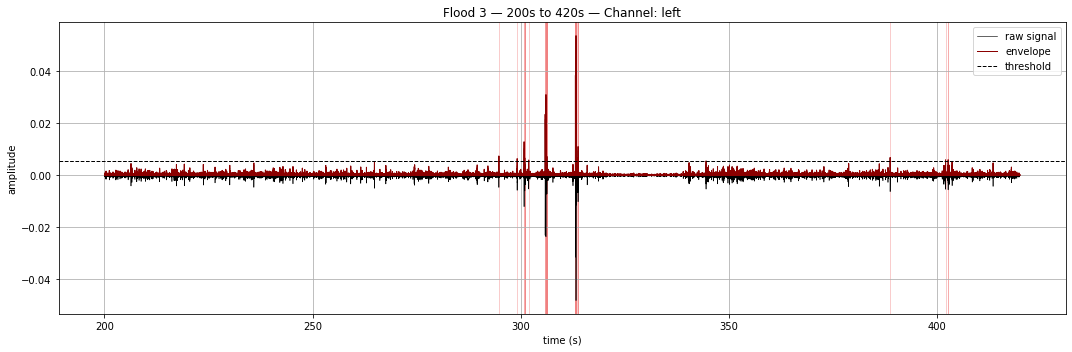

In [22]:
start_time = 200  # in seconds
end_time = 420  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Flood 3 — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_amplitude_zoom = np.max(np.abs(envelope_zoom))
print(f"Max amplitude in the zoomed-in window: {max_amplitude_zoom:.4f}")

plt.show()

### Flood 4

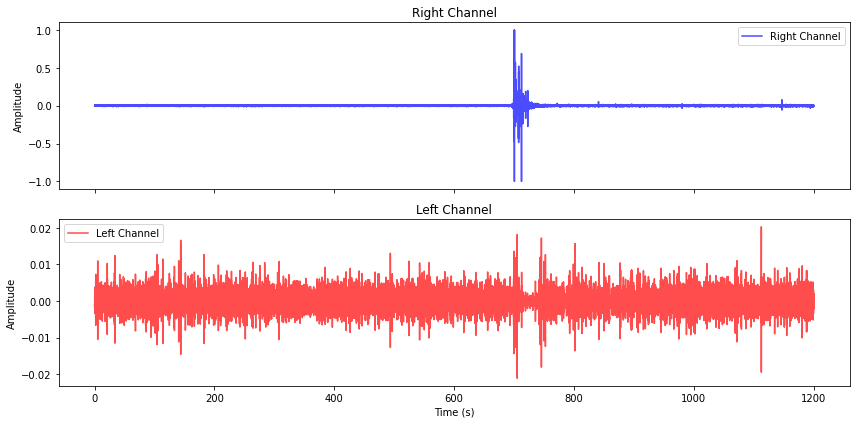

In [4]:
filepath = 'EXP-09-21-23-FLOW4/audio/Nicole_091823-000100.flac'

# load stereo signal
signal, sr = librosa.load(filepath, sr=None, mono=False)
left_channel = signal[0]
right_channel = signal[1]

#create the time axis
duration = signal.shape[-1] / sr
time = np.linspace(0, duration, signal.shape[-1])

# plot the signals
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# plot the right channel (top)
axes[0].plot(time, signal[1], label='Right Channel', color='b', alpha=0.7)
axes[0].set_title("Right Channel")
axes[0].set_ylabel("Amplitude")
axes[0].legend()

# plot the left channel (bottom)
axes[1].plot(time, signal[0], label='Left Channel', color='r', alpha=0.7)
axes[1].set_title("Left Channel")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].legend()

# adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### Flood 5

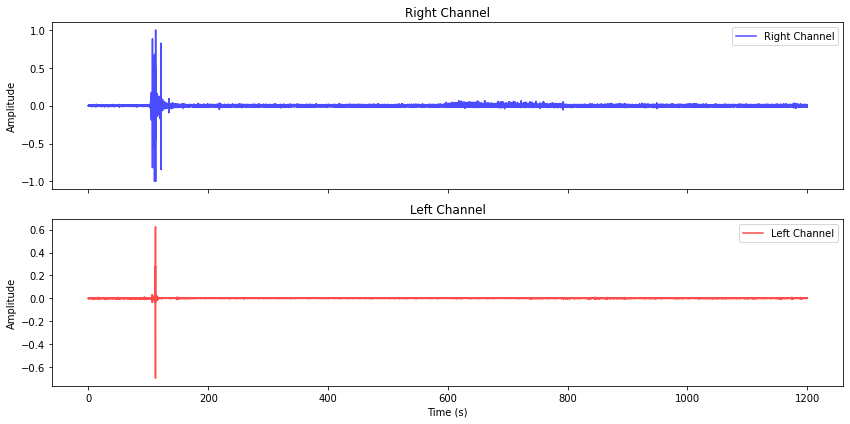

In [13]:
filepath = 'EXP-09-21-23-FLOW5/audio/Nicole_091823-000100.flac'

# load stereo signal
signal, sr = librosa.load(filepath, sr=None, mono=False)
left_channel = signal[0]
right_channel = signal[1]

#create the time axis
duration = signal.shape[-1] / sr
time = np.linspace(0, duration, signal.shape[-1])

# plot the signals
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# plot the right channel (top)
axes[0].plot(time, signal[1], label='Right Channel', color='b', alpha=0.7)
axes[0].set_title("Right Channel")
axes[0].set_ylabel("Amplitude")
axes[0].legend()

# plot the left channel (bottom)
axes[1].plot(time, signal[0], label='Left Channel', color='r', alpha=0.7)
axes[1].set_title("Left Channel")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].legend()

# adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [14]:
# === USER INPUT ===
left_gain_db = 6   # left channel gain (dB)
right_gain_db = 12 # right channel gain (dB)
use_channel = "left"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

Max amplitude in the zoomed-in window: 0.3549


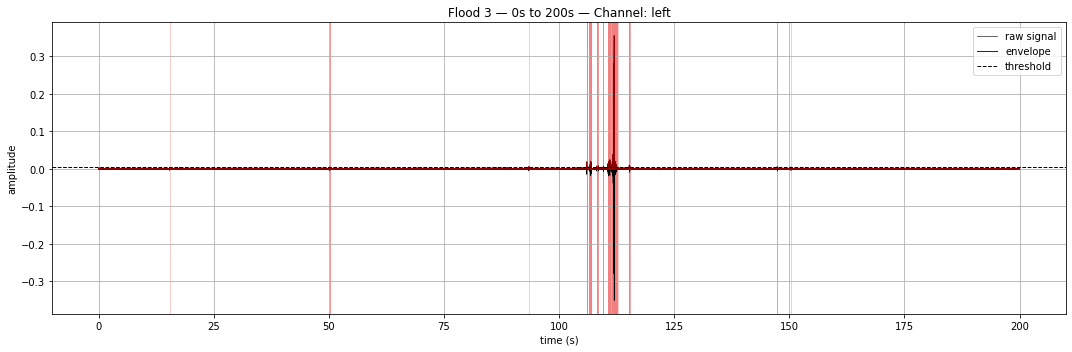

In [16]:
start_time = 0  # in seconds
end_time = 200  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Flood 3 — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_amplitude_zoom = np.max(np.abs(envelope_zoom))
print(f"Max amplitude in the zoomed-in window: {max_amplitude_zoom:.4f}")

plt.show()

### Flood 6

C:\Users\nicol\AppData\Local\Temp\ipykernel_28484\663228995.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


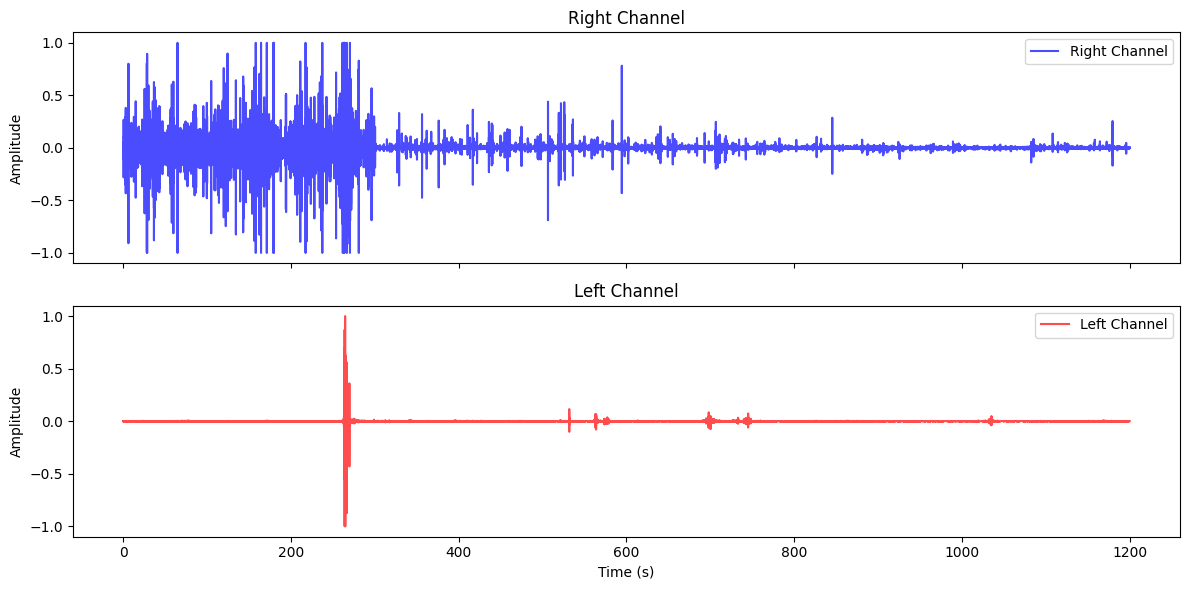

In [7]:
filepath = 'EXP-09-22-23-FLOW6/audio/Nicole_091823-000100.flac'

# load stereo signal
signal, sr = librosa.load(filepath, sr=None, mono=False)
left_channel = signal[0]
right_channel = signal[1]

#create the time axis
duration = signal.shape[-1] / sr
time = np.linspace(0, duration, signal.shape[-1])

# plot the signals
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# plot the right channel (top)
axes[0].plot(time, signal[1], label='Right Channel', color='b', alpha=0.7)
axes[0].set_title("Right Channel")
axes[0].set_ylabel("Amplitude")
axes[0].legend()

# plot the left channel (bottom)
axes[1].plot(time, signal[0], label='Left Channel', color='r', alpha=0.7)
axes[1].set_title("Left Channel")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].legend()

# adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [ ]:
# === USER INPUT ===
left_gain_db = 6   # left channel gain (dB)
right_gain_db = 12 # right channel gain (dB)
use_channel = "left"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]